In [1]:
import os
import random

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy, Precision, Recall

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16

import numpy as np
import matplotlib.pyplot as plt

E0000 00:00:1722355274.424365      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0730 16:01:14.433004336      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0730 16:01:14.433024493      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0730 16:01:14.433027985      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0730 16:01:14.433030401      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0730 16:01:14.433032721      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1722355288.615186      13 service.cc:145] XLA service 0x5714a330e610 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722355288.615243      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1722355288.615248      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1722355288.615251      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1722355288.615254      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1722355288.615257      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1722355288.615259      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1722355288.615262      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1722355288.615264      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:
# strategy = tf.distribute.MirroredStrategy()

# Custom F1Score class
### Normal tensorflow F1Score is not supported here like google colab

In [4]:
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [5]:
dataset_base_path = '/kaggle/input/book-and-notebook'
db_name = '/kaggle/input/book-and-notebook/dataset_256'

# Hyper Parameters

In [484]:
batch_size = 32
image_size = (256, 256)
learning_rate = 1e-4
lr_decay_factor = 0.09
epochs=50
label_mode = 'int'
seed=42
train_ds_size=1000
val_ds_size=400

In [485]:
# print('Replicas: ',strategy.num_replicas_in_sync)

# Batch size when using GPU

In [486]:
# batch_size = strategy.num_replicas_in_sync * 8

# Batch size when using TPU

In [487]:
batch_size = strategy.num_replicas_in_sync * 4

# Setting up random seed for deterministic output

In [488]:
tf.random.set_seed(seed)

global_generator = tf.random.Generator.from_seed(seed)
tf.random.set_global_generator(global_generator)

np.random.seed(seed)
random.seed(seed)
AUTOTUNE = tf.data.AUTOTUNE

In [489]:
print(batch_size)

32


# Reading train, validation and test dataset

In [490]:
train_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/train',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=True,
)

val_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/valid',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=False,
)

test_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/test',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=False,
)


# test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.uint8)))
# test_ds = test_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))

# Used for plotting
class_names = train_ds.class_names

Found 782 files belonging to 2 classes.
Found 106 files belonging to 2 classes.
Found 160 files belonging to 2 classes.


In [491]:
# # train_ds.map(lambda image, label: image)
# train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.uint8)))
# val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.uint8)))
# train_ds = train_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))
# val_ds = val_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))

# plot function

In [492]:
# def show(ds):
#   for imgs, labels in ds:
#     break
#   info = []
#   for i in range(12):
#     info.append((labels[i], i))
#   info.sort()

#   plt.figure(figsize=(10, 4))
#   # plt.suptitle('Dataset samples', fontsize=20)
#   for i in range(12):
#     plt.subplot(2,6,i+1)
#     plt.imshow(imgs[info[i][1]] / 255)
#     plt.axis('off')
#     plt.title('{}'.format(labels[info[i][1]]))

#   # plt.savefig("./{}.png".format('dataset-samples'), bbox_inches='tight', format='png', dpi=256)
#   plt.show();

def plot_images(dataset, title, n_images=20):
    dataset.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
    dataset_iter = iter(dataset)
    images, labels = next(dataset_iter)
    plt.figure(figsize=(12, 8))
    n_images = min(n_images, len(images))
    for i in range(n_images):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i].numpy()))
        plt.axis("off")
    plt.suptitle(title)
    # plt.savefig("./{}.png".format('dataset-samples'), bbox_inches='tight', format='png', dpi=256)
    plt.show()


# Checking if an image is blackish or not

In [493]:
def is_blackish(image, threshold=80.0):
    # Convert the image to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    
    # Calculate the mean brightness
    mean_brightness = tf.reduce_mean(grayscale_image).numpy()
#     print(mean_brightness)
    # Check if the mean brightness is below the threshold
    return mean_brightness < threshold

# Photometric augmentation functions

In [494]:
def adjust_contrast(image):
    return tf.image.adjust_contrast(image, contrast_factor=1.1)

def adjust_brightness(image):
    return tf.image.adjust_brightness(image, delta=100.0)

def adjust_saturation(image):
    return tf.image.adjust_saturation(image, saturation_factor=2)

def adjust_gamma(image):
    return tf.image.adjust_gamma(image, gamma=1.001)

def adjust_hue(image):
    return tf.image.adjust_hue(image, 0.12)

# Applying photometric functions

In [495]:
def combined_preprocessing(image):
    choice = np.random.choice(['saturation', 'contrast', 'hue', 'gamma'])
    
    if is_blackish(image):
        image = adjust_brightness(image)
#     return image
#     image = adjust_saturation(image)
    
    if choice == 'contrast':
        image = adjust_contrast(image)
    elif choice == 'gamma':
        image = adjust_gamma(image)
    elif choice == 'hue':
        image = adjust_hue(image)
    elif choice == 'saturation':
        image = adjust_saturation(image)
    return image

# Generating geometric augmented images

In [496]:
# geodatagen = ImageDataGenerator(rotation_range=35,
#         shear_range=0.20,
#         zoom_range=0.50,
#         horizontal_flip=True,
#         fill_mode='nearest')
zoomDataGen = ImageDataGenerator(zoom_range=0.50, fill_mode='nearest')
rotationDataGen = ImageDataGenerator(rotation_range=33, fill_mode='nearest')
shearDataGen = ImageDataGenerator(shear_range=0.20, fill_mode='nearest')
flipDataGen = ImageDataGenerator(horizontal_flip=True, fill_mode='nearest')

# Generating photometric augmented images

In [497]:
photodatagen = ImageDataGenerator(
    preprocessing_function=combined_preprocessing,
)

# Generating geometric images

In [498]:
train_generator_zoom = zoomDataGen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
val_generator_zoom = zoomDataGen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

train_generator_rotation = rotationDataGen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
val_generator_rotation = rotationDataGen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

train_generator_shear = shearDataGen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
val_generator_shear = shearDataGen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)


train_generator_flip = flipDataGen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
val_generator_flip = flipDataGen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


# Generating photometric images

In [499]:
photo_train_generator = photodatagen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
photo_val_generator = photodatagen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [500]:
def getImgs(gen, n):
    aug_images = []
    aug_labels = []
    for _ in range(n):
        images, labels = next(gen)
        aug_images.extend(images)
        aug_labels.extend(labels)
    
    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    return aug_images, aug_labels

# Only geometric augmented images of train data

In [501]:
images, labels = getImgs(train_generator_zoom, train_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [502]:
train_ds = train_ds.concatenate(aug_train)

In [503]:
images, labels = getImgs(train_generator_rotation, train_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [504]:
train_ds = train_ds.concatenate(aug_train)

In [505]:
images, labels = getImgs(train_generator_shear, train_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [506]:
train_ds = train_ds.concatenate(aug_train)

In [507]:
images, labels = getImgs(train_generator_flip, train_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [508]:
train_ds = train_ds.concatenate(aug_train)

# Only geometric augmented images of validation data

In [509]:
images, labels = getImgs(val_generator_zoom, val_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [510]:
val_ds = val_ds.concatenate(aug_val)

In [511]:
images, labels = getImgs(val_generator_rotation, val_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [512]:
val_ds = val_ds.concatenate(aug_val)

In [513]:
images, labels = getImgs(val_generator_shear, val_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [514]:
val_ds = val_ds.concatenate(aug_val)

In [515]:
images, labels = getImgs(val_generator_flip, val_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [516]:
val_ds = val_ds.concatenate(aug_val)

In [517]:
# train_ds = train_ds.filter(lambda x, y: False)
# val_ds = val_ds.filter(lambda x, y: False)

# Merging the geometric augmented images to actual train and validation dataset

In [518]:
# train_ds = train_ds.concatenate(aug_train)
# val_ds = val_ds.concatenate(aug_val)

# Photometric Augmentation of train data

In [519]:
images, labels = getImgs(photo_train_generator, int(train_ds_size * 2.5) // batch_size)

# images = images.astype(np.float16)
# labels = labels.astype(np.uint8)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

# Photometric Augmentation of validation data

In [520]:
images, labels = getImgs(photo_val_generator, int(val_ds_size * 2.5) // batch_size)

# images = images.astype(np.float16)
# labels = labels.astype(np.uint8)
labels = labels.astype(np.int32)


aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

# Ploting the photometric aug train data

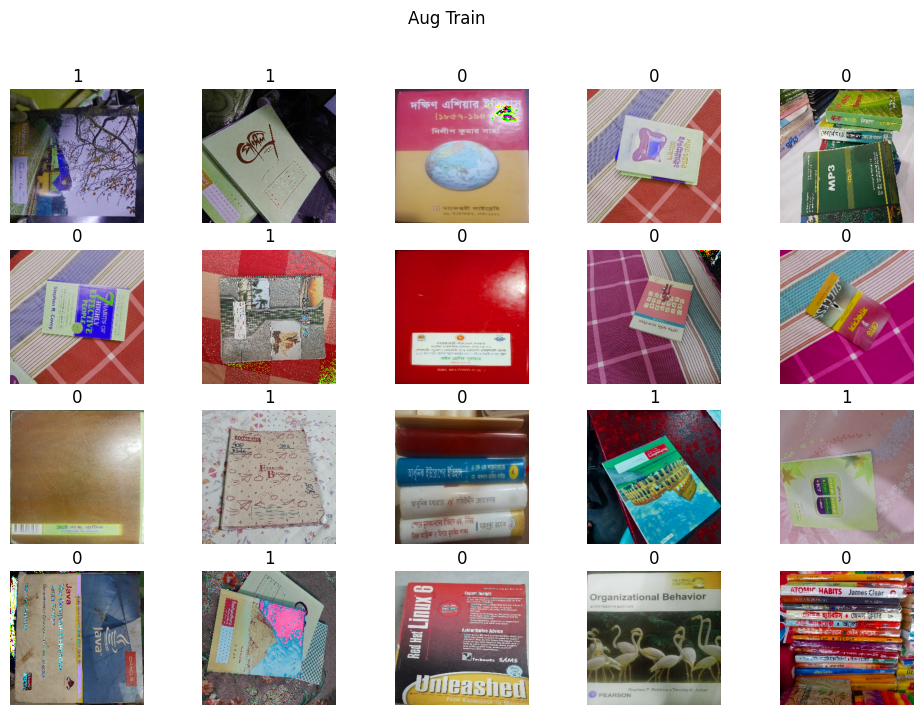

In [521]:
plot_images(aug_train, 'Aug Train')

# Merging the photometric augmented images to actual train and validation dataset

In [522]:
train_ds = train_ds.concatenate(aug_train)
val_ds = val_ds.concatenate(aug_val)

# Shuffling the datasets

In [523]:
train_ds = train_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
# val_ds = val_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)

In [524]:
# aug_train = aug_train.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
# plot_images(aug_train, 'Aug Train')

In [525]:
# plot_images(val_ds, 'Validation Dataset')

In [526]:
# plot_images(test_ds, 'Test Dataset')

In [527]:
# !pip install -q --upgrade keras-cv

In [528]:
# import keras_cv
# mix_up = keras_cv.layers.MixUp()
# cut_mix = keras_cv.layers.CutMix()

In [529]:
# def mix_up_f(images, labels):
#     labels = tf.one_hot(labels, 2)
#     labels = tf.cast(labels, tf.float32)
#     samples = {"images": images, "labels": labels}
#     samples = mix_up(samples, training=True)
#     return samples["images"], tf.cast(samples["labels"], tf.uint8)

In [530]:
# def cut_mix_f(images, labels):
#     labels = tf.one_hot(labels, 2)
#     labels = tf.cast(labels, tf.float32)
#     samples = {"images": images, "labels": labels}
#     samples = cut_mix(samples, training=True)
#     return samples["images"], tf.cast(samples["labels"], tf.uint8)

In [531]:
# def mix_up_cut_mix_augmentation(dataset):
#     mix_up_images = []
#     mix_up_labels = []

#     for images, labels in dataset:
#         labels = tf.argmax(labels, axis=-1)
#         labels = tf.cast(labels, tf.uint8)
#         images = tf.cast(images, tf.float16)
#         mix_up_images.append(images.numpy())
#         mix_up_labels.append(labels.numpy())

#     mix_up_images = np.concatenate(mix_up_images, axis=0)
#     mix_up_labels = np.concatenate(mix_up_labels, axis=0)
#     return tf.data.Dataset.from_tensor_slices((mix_up_images, mix_up_labels)).batch(batch_size)

In [532]:
# def mix_up_cut_mix(dataset, op):
#     ds=None
#     if op == "mix_up":
#         ds = dataset.map(lambda x, y : mix_up_f(x, y), num_parallel_calls=AUTOTUNE)
#     elif op == "cut_mix":
#         ds = dataset.map(lambda x, y : cut_mix_f(x, y), num_parallel_calls=AUTOTUNE)
#     return mix_up_cut_mix_augmentation(ds)

In [533]:
# mix_up_train = mix_up_cut_mix(tmp_train_ds, "mix_up")
# cut_mix_train = mix_up_cut_mix(tmp_train_ds, "cut_mix")

In [534]:
# mix_up_val = mix_up_cut_mix(tmp_val_ds, "mix_up")
# cut_mix_val = mix_up_cut_mix(tmp_val_ds, "cut_mix")

In [535]:
# plot_images(mix_up_train, 'Mix Up Dataset')

In [536]:
# plot_images(cut_mix_train, 'cut mix dataset')

In [537]:
# train_ds = train_ds.concatenate(mix_up_train)
# train_ds = train_ds.concatenate(cut_mix_train)

In [538]:
# val_ds = val_ds.concatenate(mix_up_val)
# val_ds = val_ds.concatenate(cut_mix_val)

In [539]:
# aug_train_cut_mix = mix_up_cut_mix(aug_train, "cut_mix")
# train_ds = train_ds.concatenate(aug_train_cut_mix)

In [540]:
# aug_val_cut_mix = mix_up_cut_mix(aug_val, "cut_mix")
# val_ds = val_ds.concatenate(aug_val_cut_mix)

In [541]:
# aug_train_mix_up = mix_up_cut_mix(aug_train, "mix_up")
# train_ds = train_ds.concatenate(aug_train_mix_up)

In [542]:
# aug_val_mix_up = mix_up_cut_mix(aug_val, "mix_up")
# val_ds = val_ds.concatenate(aug_val_mix_up)

In [543]:
# train_ds = train_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
# val_ds = val_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)

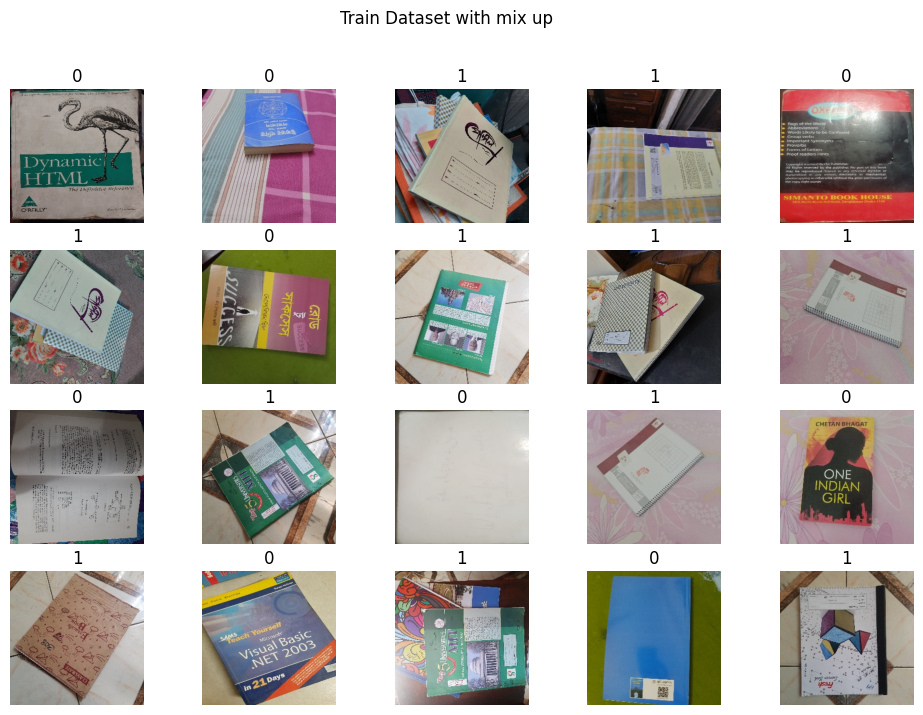

In [544]:
plot_images(train_ds, 'Train Dataset with mix up')

In [545]:
import gc
gc.collect()

94481

In [546]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

# FCNN Model

In [547]:
with strategy.scope():

    inputs = Input(shape=image_size + (3,))
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    fc_model = keras.Model(inputs, outputs, name='FC_Model')
    fc_model.summary()
    
    fc_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(name='accuracy')]
    )

Model: "FC_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │    50,331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,808,449 (193.82 MB)

 Trainable params: 50,808,449 (193.82 MB)

 Non-trainable params: 0 (0.00 B)

In [548]:
class CustomLearningRateSchedule(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, decay_factor=0.1):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay_factor = decay_factor

    def on_epoch_begin(self, epoch, logs=None):
            lr = self.model.optimizer.learning_rate
            lr = self.initial_lr * tf.exp(-self.decay_factor * epoch)
            self.model.optimizer.learning_rate = lr

In [549]:
# checkpoint_dir = './checkpoints'

# Training FCNN model

In [550]:
with strategy.scope():
#     tf.saved_model.save(fc_model, 'fc_model.keras', options=save_locally)

    history = fc_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=3, verbose=1),
        #             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
                ModelCheckpoint('FC_Model.keras', save_weights_only=False, save_best_only=True, verbose=1),
                EarlyStopping(patience=15, restore_best_weights=True),
            ],
        )

Epoch 1/50


2024-07-30 18:42:16.176877: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1722364937.074973     841 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6caa59e07067ae34:0:0), session_name()


  3/226 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2639 - loss: 69.1969        

I0000 00:00:1722365024.529430     841 tpu_compile_op_common.cc:245] Compilation of 6caa59e07067ae34:0:0 with session name  took 1m27.454399961s and succeeded
I0000 00:00:1722365024.534526     841 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6caa59e07067ae34:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7521255343359039656", property.function_library_fingerprint = 1135819221616483292, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722365024.534567     841 tpu_compilation_cache_interface.cc:541] After adding entry for key 6

 10/226 ━━━━━━━━━━━━━━━━━━━━ 15:51 4s/step - accuracy: 0.4302 - loss: 115.0418

I0000 00:00:1722365064.067991     788 tpu_compile_op_common.cc:245] Compilation of 9d808307944d1bc5:0:0 with session name  took 39.448355217s and succeeded
I0000 00:00:1722365064.072369     788 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9d808307944d1bc5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7521255343359039656", property.function_library_fingerprint = 1135819221616483292, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722365064.072410     788 tpu_compilation_cache_interface.cc:541] After adding entry for key 9d8

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5638 - loss: 132.2643

2024-07-30 18:44:32.880659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
I0000 00:00:1722365073.100265     804 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(93402998ba7b2e30:0:0), session_name()
I0000 00:00:1722365161.119659     804 tpu_compile_op_common.cc:245] Compilation of 93402998ba7b2e30:0:0 with session name  took 1m28.01934445s and succeeded
I0000 00:00:1722365161.122280     804 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(93402998ba7b2e30:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17638264628322905886", property.function_library_fingerprint = 2351977130215263181, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t


Epoch 1: val_loss improved from inf to 147.81178, saving model to FC_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 281s 811ms/step - accuracy: 0.5640 - loss: 132.1891 - val_accuracy: 0.5161 - val_loss: 147.8118 - learning_rate: 1.0000e-04
Epoch 2/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6942 - loss: 48.9317
Epoch 2: val_loss improved from 147.81178 to 110.41066, saving model to FC_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.6939 - loss: 48.8358 - val_accuracy: 0.5090 - val_loss: 110.4107 - learning_rate: 1.0000e-04
Epoch 3/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7255 - loss: 28.5295
Epoch 3: val_loss improved from 110.41066 to 44.54886, saving model to FC_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.7252 - loss: 28.5580 - val_accuracy: 0.4803 - val_loss: 44.5489 - learning_rate: 1.0000e-04
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6908 - loss: 28.6419
Epoch 4: val_loss improved fr

# FCNN graph comparisons

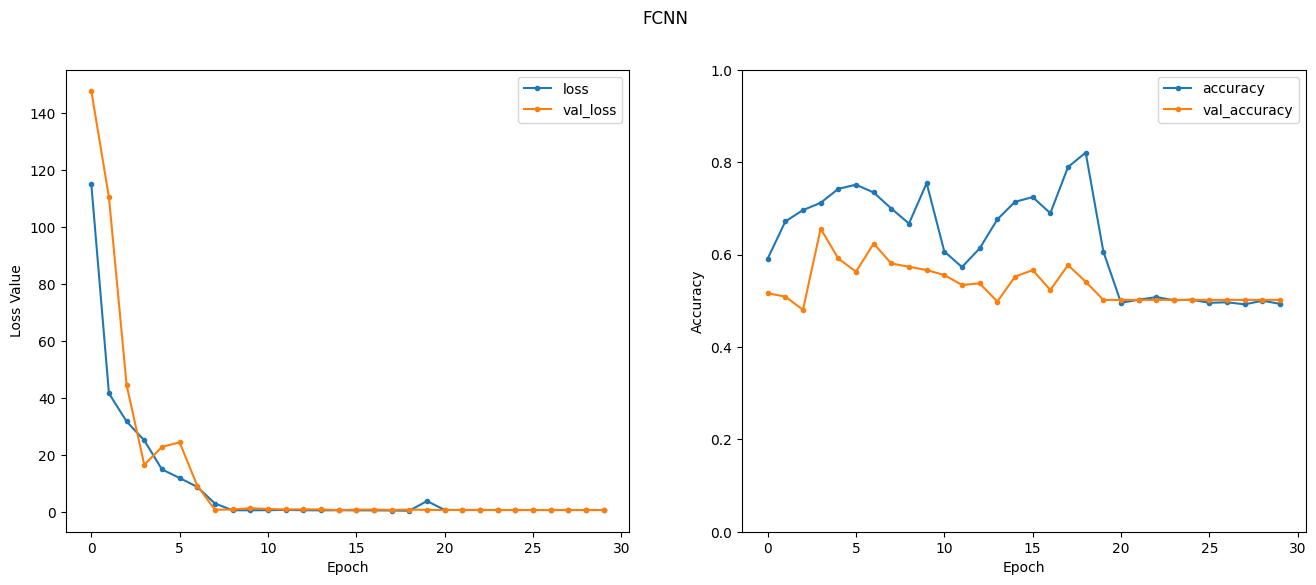

In [551]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('FCNN')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best FCNN checkpoints and compiling

In [552]:
with strategy.scope():

    fc_model = tf.keras.models.load_model('FC_Model.keras')

    fc_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating FCNN

In [553]:
with strategy.scope():

    eval = fc_model.evaluate(test_ds, return_dict=True)

    print(eval)

2024-07-30 18:54:07.966593: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722365648.260409     812 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6c34239a69f6fa58:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 23ms/step - accuracy: 0.8417 - f1score: 0.0741 - loss: 0.5932 - precision: 0.3333 - recall: 0.0417           
{'accuracy': 0.6499999761581421, 'f1score': 0.2222221940755844, 'loss': 0.6182740330696106, 'precision': 1.0, 'recall': 0.125}


I0000 00:00:1722365736.591879     812 tpu_compile_op_common.cc:245] Compilation of 6c34239a69f6fa58:0:0 with session name  took 1m28.331411446s and succeeded
I0000 00:00:1722365736.595075     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6c34239a69f6fa58:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2961498599421273125", property.function_library_fingerprint = 6200340799948145393, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722365736.595124     812 tpu_compilation_cache_interface.cc:541] After adding entry for key 6

In [554]:
gc.collect()

270899

# SCNN model

In [555]:
with strategy.scope():
    inputs = Input(shape=image_size + (3,))
    x = Conv2D(filters=128, kernel_size=5, padding='same', activation='relu')(inputs)
    x = Conv2D(filters=128, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    cnn_model = Model(inputs, outputs, name='SCNN_Model')
    cnn_model.summary()
    
    cnn_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy')])

Model: "SCNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 256, 256, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 256, 256, 128)  │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,518,593 (40.13 MB)

 Trainable params: 10,518,593 (40.13 MB)

 Non-trainable params: 0 (0.00 B)

# Training SCNN model

In [556]:
with strategy.scope():
 
    history = cnn_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('SCNN_Model.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


2024-07-30 18:55:59.645432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1722365760.499185     823 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9b8c42945bdc9924:0:0), session_name()


  3/226 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.5972 - loss: 1.3543    

I0000 00:00:1722365767.902516     823 tpu_compile_op_common.cc:245] Compilation of 9b8c42945bdc9924:0:0 with session name  took 7.403283592s and succeeded
I0000 00:00:1722365767.912427     823 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9b8c42945bdc9924:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1420220317144423490", property.function_library_fingerprint = 1817987258684477669, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722365767.912464     823 tpu_compilation_cache_interface.cc:541] After adding entry for key 9b8c

 29/226 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5141 - loss: 0.9753

I0000 00:00:1722365769.163295     836 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9df8a9df4a296fb4:0:0), session_name()


 34/226 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.5098 - loss: 0.9519

I0000 00:00:1722365782.779934     836 tpu_compile_op_common.cc:245] Compilation of 9df8a9df4a296fb4:0:0 with session name  took 13.616572382s and succeeded
I0000 00:00:1722365782.789279     836 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9df8a9df4a296fb4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1420220317144423490", property.function_library_fingerprint = 1817987258684477669, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722365782.789326     836 tpu_compilation_cache_interface.cc:541] After adding entry for key 9df

225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5223 - loss: 0.7635

I0000 00:00:1722365793.468364     751 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2137933aed776a60:0:0), session_name()
I0000 00:00:1722365798.160628     751 tpu_compile_op_common.cc:245] Compilation of 2137933aed776a60:0:0 with session name  took 4.692218978s and succeeded
I0000 00:00:1722365798.163078     751 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2137933aed776a60:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6382274561269662402", property.function_library_fingerprint = 2170655621898756511, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embeddin


Epoch 1: val_loss improved from inf to 0.70169, saving model to SCNN_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 191ms/step - accuracy: 0.5226 - loss: 0.7630 - val_accuracy: 0.5663 - val_loss: 0.7017 - learning_rate: 1.0000e-04
Epoch 2/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6463 - loss: 0.6707
Epoch 2: val_loss improved from 0.70169 to 0.69228, saving model to SCNN_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.6461 - loss: 0.6708 - val_accuracy: 0.5197 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 3/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6896 - loss: 0.6159
Epoch 3: val_loss improved from 0.69228 to 0.67663, saving model to SCNN_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.6897 - loss: 0.6157 - val_accuracy: 0.5878 - val_loss: 0.6766 - learning_rate: 1.0000e-04
Epoch 4/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7778 - loss: 0.5299
Epoch 4: val_loss did not improve from 0.6766

# SCNN graph comparisons

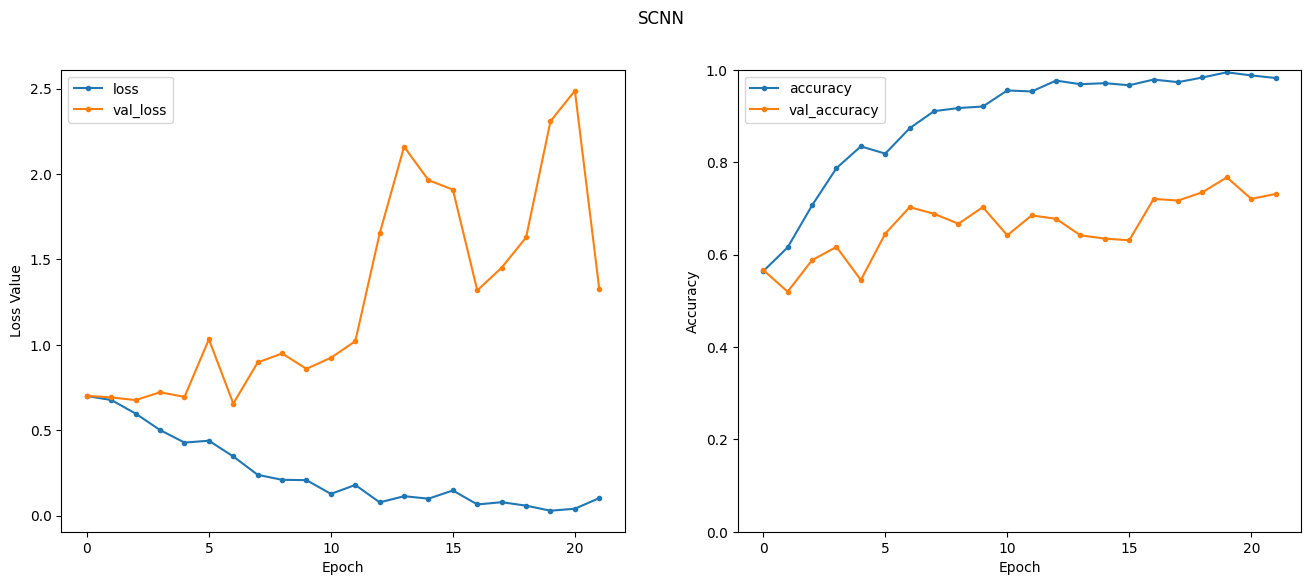

In [557]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('SCNN')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best SCNN checkpoints and compiling

In [558]:
with strategy.scope():
    
    cnn_model = tf.keras.models.load_model('SCNN_Model.keras')

    cnn_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating SCNN

In [559]:
with strategy.scope():
    
    eval = cnn_model.evaluate(test_ds, return_dict=True)

    print(eval)

2024-07-30 19:03:39.645752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722366219.934994     764 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d365d5bcf287ec4d:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8153 - f1score: 0.2937 - loss: 0.3765 - precision: 0.3611 - recall: 0.2500         
{'accuracy': 0.800000011920929, 'f1score': 0.714285671710968, 'loss': 0.4001549780368805, 'precision': 0.8333333134651184, 'recall': 0.625}


I0000 00:00:1722366225.252785     764 tpu_compile_op_common.cc:245] Compilation of d365d5bcf287ec4d:0:0 with session name  took 5.317718804s and succeeded
I0000 00:00:1722366225.256083     764 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d365d5bcf287ec4d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9248420146421410640", property.function_library_fingerprint = 6316309233186925701, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722366225.256116     764 tpu_compilation_cache_interface.cc:541] After adding entry for key d365

# VGG16 Model

In [560]:
with strategy.scope():

    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=image_size+(3,))

    inputs = vgg16.input
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    vgg16_model = Model(inputs, outputs, name='VGG16_Model')
    vgg16_model.summary()
    
    vgg16_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy')])

Model: "VGG16_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 23,136,577 (88.26 MB)

 Non-trainable params: 0 (0.00 B)

# Training VGG16(no weights) model

In [561]:
with strategy.scope():

    history = vgg16_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('VGG16_Model.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


I0000 00:00:1722366250.147970     766 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(75761326f3db9481:0:0), session_name()


  3/226 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5417 - loss: 0.8708    

I0000 00:00:1722366259.010613     766 tpu_compile_op_common.cc:245] Compilation of 75761326f3db9481:0:0 with session name  took 8.86258595s and succeeded
I0000 00:00:1722366259.022773     766 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(75761326f3db9481:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5416537650564748556", property.function_library_fingerprint = 475189130450214384, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722366259.022809     766 tpu_compilation_cache_interface.cc:541] After adding entry for key 757613

  9/226 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.5166 - loss: 0.8925

I0000 00:00:1722366259.433958     819 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9cbc9b98b1ea3301:0:0), session_name()


 14/226 ━━━━━━━━━━━━━━━━━━━━ 2:30 709ms/step - accuracy: 0.4991 - loss: 0.8736

I0000 00:00:1722366268.085829     819 tpu_compile_op_common.cc:245] Compilation of 9cbc9b98b1ea3301:0:0 with session name  took 8.651827443s and succeeded
I0000 00:00:1722366268.098478     819 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9cbc9b98b1ea3301:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5416537650564748556", property.function_library_fingerprint = 475189130450214384, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722366268.098514     819 tpu_compilation_cache_interface.cc:541] After adding entry for key 9cbc9

225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5217 - loss: 0.7224

2024-07-30 19:04:41.510427: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
I0000 00:00:1722366281.734824     760 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d90640e8ad5c5304:0:0), session_name()
I0000 00:00:1722366288.300549     760 tpu_compile_op_common.cc:245] Compilation of d90640e8ad5c5304:0:0 with session name  took 6.565677351s and succeeded
I0000 00:00:1722366288.303787     760 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d90640e8ad5c5304:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4895457495639778033", property.function_library_fingerprint = 6513262156612489889, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topo


Epoch 1: val_loss improved from inf to 0.69722, saving model to VGG16_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - accuracy: 0.5218 - loss: 0.7222 - val_accuracy: 0.5018 - val_loss: 0.6972 - learning_rate: 1.0000e-04
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5191 - loss: 0.6937
Epoch 2: val_loss did not improve from 0.69722
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.5191 - loss: 0.6937 - val_accuracy: 0.5484 - val_loss: 0.7523 - learning_rate: 1.0000e-04
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4729 - loss: 0.6976
Epoch 3: val_loss improved from 0.69722 to 0.69320, saving model to VGG16_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.4730 - loss: 0.6976 - val_accuracy: 0.5018 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 4/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5127 - loss: 0.6937
Epoch 4: val_loss improved from 0.69320 to 0.69256, saving model to VGG16_Model.k

# VGG16(no weights) graph comparisons

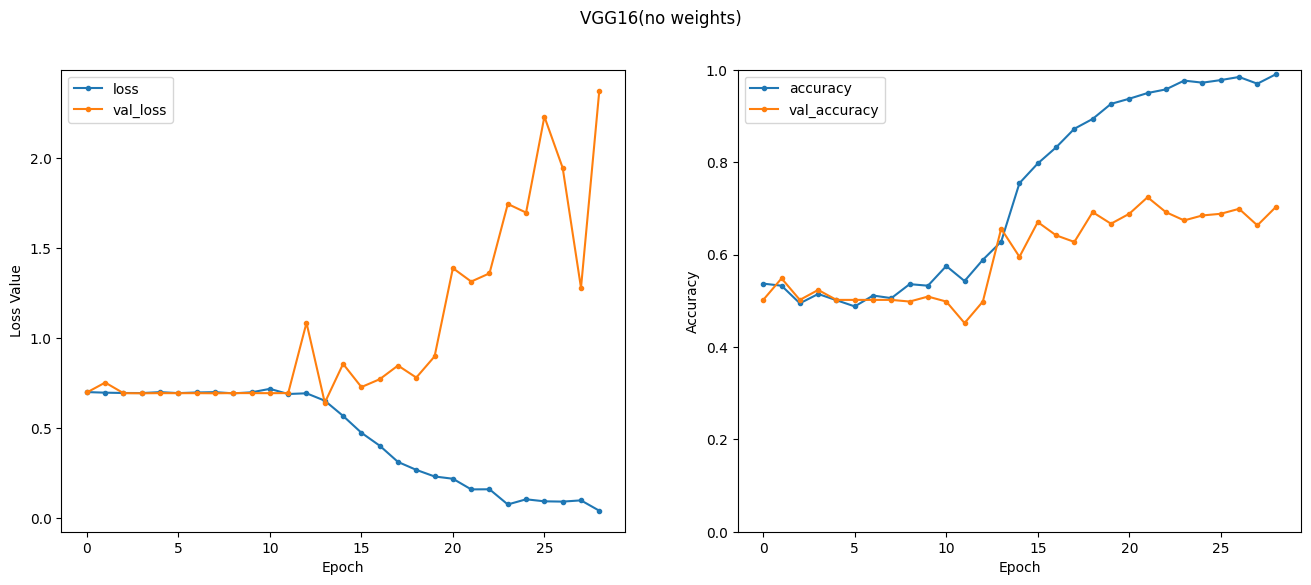

In [562]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('VGG16(no weights)')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best VGG16(no weights) checkpoints and compiling

In [563]:
with strategy.scope():
    
    vgg16_model = tf.keras.models.load_model('VGG16_Model.keras')

    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating VGG16(no weights)

In [564]:
with strategy.scope():
    
    eval = vgg16_model.evaluate(test_ds, return_dict=True)

    print(eval)

2024-07-30 19:13:53.872030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722366834.157438     828 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6fc40288dd87c20b:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8014 - f1score: 0.3333 - loss: 0.3930 - precision: 0.3333 - recall: 0.3333          


I0000 00:00:1722366841.074686     828 tpu_compile_op_common.cc:245] Compilation of 6fc40288dd87c20b:0:0 with session name  took 6.917204975s and succeeded
I0000 00:00:1722366841.078318     828 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6fc40288dd87c20b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16234047809875090239", property.function_library_fingerprint = 9300376236346691723, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722366841.078350     828 tpu_compilation_cache_interface.cc:541] After adding entry for key 6fc

{'accuracy': 0.800000011920929, 'f1score': 0.7499999403953552, 'loss': 0.40129607915878296, 'precision': 0.75, 'recall': 0.75}


# VGG16 with imagenet weights

In [565]:
with strategy.scope():

    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=image_size+(3,))

    inputs = vgg16.input
    x = Flatten()(vgg16.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    vgg16_model = Model(inputs, outputs, name='VGG16_Model_Half_TL')
    vgg16_model.summary(show_trainable=True)
    
    base_vgg16_model = vgg16_model
    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(name='accuracy')]
    )

Model: "VGG16_Model_Half_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_19 (InputLayer) │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_19 (Flatten)        │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_78 (Dense)            │ (None, 256)           │  8,388,864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_79 (Dense)            │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_80 (Dense)            │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 23,136,577 (88.26 MB)

 Non-trainable params: 0 (0.00 B)

# Freezing all the layers except the last 4

In [566]:
with strategy.scope():

    for layer in vgg16_model.layers[:-4]:
      layer.trainable = False
    vgg16_model.summary(show_trainable=True)

Model: "VGG16_Model_Half_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_19 (InputLayer) │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_19 (Flatten)        │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_78 (Dense)            │ (None, 256)           │  8,388,864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_79 (Dense)            │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_80 (Dense)            │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 8,421,889 (32.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Apply Preprocessing Function
#### Since we are using pretrained weights, we need to preprocess our inputs with an appropiate preprocessing function. One way of doing this is to map the preprocessing function to the dataset object.

In [567]:
prep_train_ds = train_ds.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y))
prep_val_ds = val_ds.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y))
prep_test_ds = test_ds.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y))

# Training VGG16 with imagenet and freezed layers

In [568]:
with strategy.scope():

    history = vgg16_model.fit(
        prep_train_ds,
        validation_data=prep_val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('VGG16_Model_Half_TL.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


I0000 00:00:1722366856.405224     795 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9e7b8c17a8eeed85:0:0), session_name()


  7/226 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7080 - loss: 1.5776 

I0000 00:00:1722366863.123890     795 tpu_compile_op_common.cc:245] Compilation of 9e7b8c17a8eeed85:0:0 with session name  took 6.718607299s and succeeded
I0000 00:00:1722366863.128440     795 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9e7b8c17a8eeed85:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16765528949222079117", property.function_library_fingerprint = 11482322806250423730, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722366863.128475     795 tpu_compilation_cache_interface.cc:541] After adding entry for key 9e

 41/226 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6973 - loss: 1.7821

I0000 00:00:1722366864.156242     749 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ccccf4a8589df1e0:0:0), session_name()


 49/226 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.7096 - loss: 1.7421

I0000 00:00:1722366868.683534     749 tpu_compile_op_common.cc:245] Compilation of ccccf4a8589df1e0:0:0 with session name  took 4.527238925s and succeeded
I0000 00:00:1722366868.687695     749 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ccccf4a8589df1e0:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16765528949222079117", property.function_library_fingerprint = 11482322806250423730, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722366868.687727     749 tpu_compilation_cache_interface.cc:541] After adding entry for key cc

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8320 - loss: 1.0639

I0000 00:00:1722366875.217891     754 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3d63bcfd46c55480:0:0), session_name()
I0000 00:00:1722366881.792344     754 tpu_compile_op_common.cc:245] Compilation of 3d63bcfd46c55480:0:0 with session name  took 6.574405241s and succeeded
I0000 00:00:1722366881.796053     754 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3d63bcfd46c55480:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_12099633659698711314", property.function_library_fingerprint = 9219770188325591235, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embeddi


Epoch 1: val_loss improved from inf to 0.93783, saving model to VGG16_Model_Half_TL.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.8323 - loss: 1.0617 - val_accuracy: 0.8853 - val_loss: 0.9378 - learning_rate: 1.0000e-04
Epoch 2/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9790 - loss: 0.0806
Epoch 2: val_loss improved from 0.93783 to 0.76333, saving model to VGG16_Model_Half_TL.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9790 - loss: 0.0812 - val_accuracy: 0.8530 - val_loss: 0.7633 - learning_rate: 1.0000e-04
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9780 - loss: 0.1377
Epoch 3: val_loss did not improve from 0.76333
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9780 - loss: 0.1379 - val_accuracy: 0.8208 - val_loss: 2.4069 - learning_rate: 1.0000e-04
Epoch 4/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9946 - loss: 0.0699
Epoch 4: val_loss did not improve from 0.76333
226/226 ━━━━━━━━━━

# Plot VGG16(Half) graph comparisons

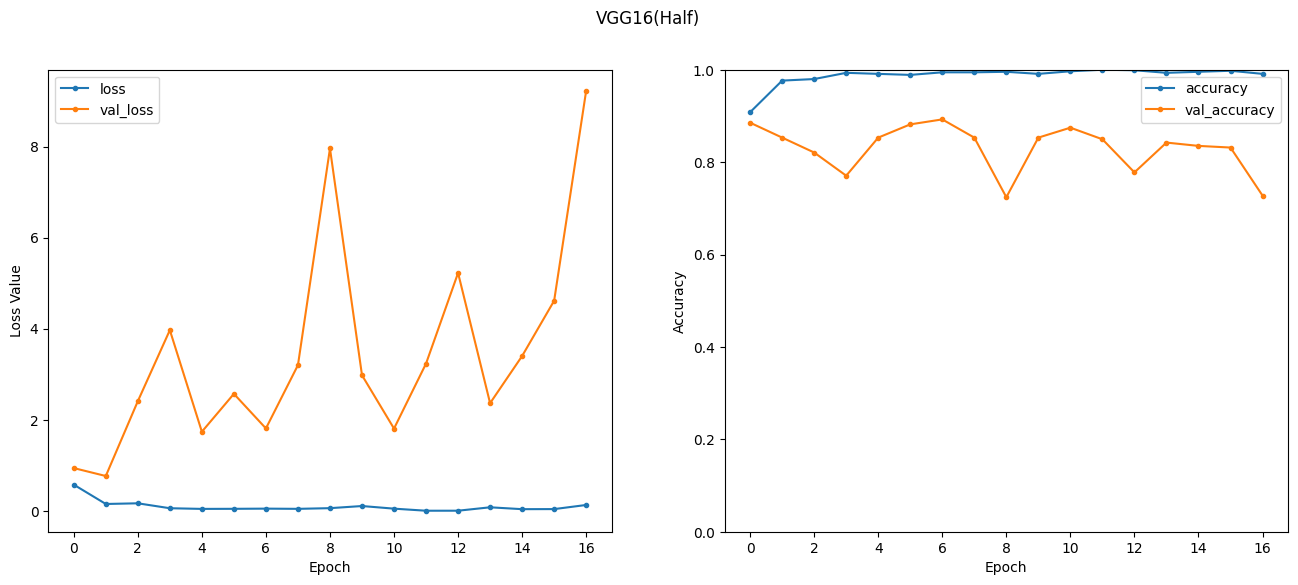

In [569]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('VGG16(Half)')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best VGG16(Half) checkpoints and compiling

In [570]:
with strategy.scope():
    
    vgg16_model = tf.keras.models.load_model('VGG16_Model_Half_TL.keras')

    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating VGG16(Half)

In [571]:
with strategy.scope():
    
    eval = vgg16_model.evaluate(prep_test_ds, return_dict=True)

    print(eval)

2024-07-30 19:18:24.434454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722367104.870322     827 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(66d310d4def81d0b:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.8347 - f1score: 0.4296 - loss: 0.8399 - precision: 0.3778 - recall: 0.5000         


I0000 00:00:1722367111.477930     827 tpu_compile_op_common.cc:245] Compilation of 66d310d4def81d0b:0:0 with session name  took 6.607556502s and succeeded
I0000 00:00:1722367111.480751     827 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(66d310d4def81d0b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13206338737101495407", property.function_library_fingerprint = 13447511505964845743, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722367111.480788     827 tpu_compilation_cache_interface.cc:541] After adding entry for key 66

{'accuracy': 0.8999999761581421, 'f1score': 0.8888888955116272, 'loss': 0.5691538453102112, 'precision': 0.800000011920929, 'recall': 1.0}


# Unfreezing all the layers and train them all

In [572]:
with strategy.scope():

    for layer in vgg16_model.layers:
      layer.trainable = True
    vgg16_model.summary(show_trainable=True)

Model: "VGG16_Model_Half_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_19 (InputLayer) │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_19 (Flatten)        │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_78 (Dense)            │ (None, 256)           │  8,388,864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_79 (Dense)            │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_80 (Dense)            │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 23,136,577 (88.26 MB)

 Non-trainable params: 0 (0.00 B)

# Training VGG16(FULL) model

In [573]:
with strategy.scope():

    base_vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(name='accuracy')]
    )
    
    history = base_vgg16_model.fit(
        prep_train_ds,
        validation_data=prep_val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('VGG16_Model_Full_TL.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


I0000 00:00:1722367122.209619     777 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(bfc4dfb06fdb88ab:0:0), session_name()


  7/226 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 1.0000 - loss: 0.0027     

I0000 00:00:1722367128.947701     777 tpu_compile_op_common.cc:245] Compilation of bfc4dfb06fdb88ab:0:0 with session name  took 6.738035635s and succeeded
I0000 00:00:1722367128.953512     777 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bfc4dfb06fdb88ab:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16855253232202531325", property.function_library_fingerprint = 11297750167230735026, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722367128.953554     777 tpu_compilation_cache_interface.cc:541] After adding entry for key bf

 13/226 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 1.0000 - loss: 0.0023

I0000 00:00:1722367129.241492     762 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4935df848185e783:0:0), session_name()


 18/226 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.9984 - loss: 0.0037 

I0000 00:00:1722367133.260730     762 tpu_compile_op_common.cc:245] Compilation of 4935df848185e783:0:0 with session name  took 4.019201593s and succeeded
I0000 00:00:1722367133.264405     762 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4935df848185e783:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16855253232202531325", property.function_library_fingerprint = 11297750167230735026, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722367133.264443     762 tpu_compilation_cache_interface.cc:541] After adding entry for key 49

224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9890 - loss: 0.0637
Epoch 1: val_loss improved from inf to 6.27038, saving model to VGG16_Model_Full_TL.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9889 - loss: 0.0641 - val_accuracy: 0.8459 - val_loss: 6.2704 - learning_rate: 1.0000e-04
Epoch 2/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9893 - loss: 0.1407
Epoch 2: val_loss improved from 6.27038 to 4.36395, saving model to VGG16_Model_Full_TL.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9892 - loss: 0.1409 - val_accuracy: 0.8925 - val_loss: 4.3639 - learning_rate: 1.0000e-04
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9860 - loss: 0.2485
Epoch 3: val_loss improved from 4.36395 to 3.35260, saving model to VGG16_Model_Full_TL.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9860 - loss: 0.2486 - val_accuracy: 0.8746 - val_loss: 3.3526 - learning_rate: 1.0000e-04
Epoch 4/50
224/226 ━━━━━━━━━━━━

# VGG16(Full) graph comparisons

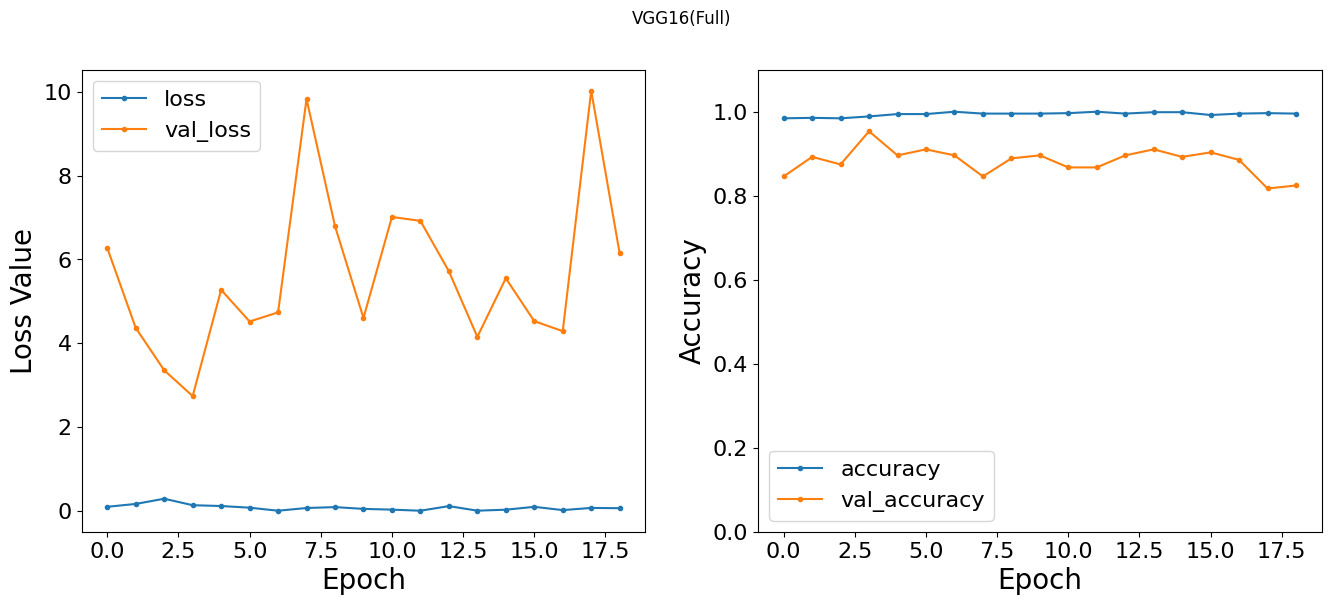

In [574]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('VGG16(Full)')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Loss Value',fontsize=20)
plt.yticks(fontsize=16)
plt.legend(['loss', 'val_loss'],fontsize=16)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Accuracy',fontsize=20)
plt.yticks(fontsize=16)
plt.ylim([0, 1.1])
plt.legend(['accuracy', 'val_accuracy'],fontsize=16)

# plt.savefig("./{}.eps".format('vgg-c-2'), bbox_inches='tight', format='eps', dpi=1000)
plt.show()

# Loading best VGG16(Full) checkpoints and compiling

In [575]:
with strategy.scope():
    
    vgg16_model = tf.keras.models.load_model('VGG16_Model_Full_TL.keras')

    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating VGG16(Full)

In [576]:
with strategy.scope():
    
    eval = vgg16_model.evaluate(prep_test_ds, return_dict=True)

    print(eval)

2024-07-30 19:23:03.500446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722367383.881806     779 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(44705d27c27830b3:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 1.0000 - f1score: 0.5000 - loss: 6.1084e-12 - precision: 0.5000 - recall: 0.5000         
{'accuracy': 1.0, 'f1score': 1.0, 'loss': 1.127709384207698e-11, 'precision': 1.0, 'recall': 1.0}


I0000 00:00:1722367390.293893     779 tpu_compile_op_common.cc:245] Compilation of 44705d27c27830b3:0:0 with session name  took 6.412033223s and succeeded
I0000 00:00:1722367390.297456     779 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(44705d27c27830b3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8072207238829191289", property.function_library_fingerprint = 17844715075140391067, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722367390.297491     779 tpu_compilation_cache_interface.cc:541] After adding entry for key 447